In [1]:
import math
import numpy as np
from cv2 import VideoCapture
import matplotlib.pyplot as plt
from matplotlib import colors
import Global
from vision.functions import vision_init, get_thymio
from vision.utils import print_error
from kalman_filter import KalmanFilter
import math
import MotionControl
import local_nav
from datetime import datetime


In [2]:
#Connecting to the tymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())

Node 459c102c-e51f-4d84-ba38-ef5cd6b70951

In [3]:
# creating Thymio and Kalman filter objects
thymio = MotionControl.Control(node,client)
tracker = KalmanFilter()
thymio.set_LEDs("off")

init


In [4]:
# lock the camera resource
cap = VideoCapture(0)

2023-12-07 11:48:44.826 python[35996:1775303] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [5]:
grid = None
obs = []
obs_grid = None
targets = []
goal = []

# import constants
from vision.constants import grid_height_cells, grid_width_cells

In [6]:
#  vision initialization

flag, grid, obs, obs_grid, targets, goal = vision_init(cap)

if not flag:
    print_error("Error in main: Vision init failed")
    assert 0  # vision init failed

# to visualize results
if False:
    from cv2 import imwrite
    from vision.functions import visualize_data
    out_img, _ = visualize_data(grid, None, obs, obs_grid, targets, goal)
    imwrite('vision_init_result.jpg', out_img)


# Extracting target to be a tuple and not a lis of lists
goals_in_green = tuple([item for sublist in targets for item in sublist])
# Extracting goal to be a tuple and not a lis of lists
goals_in_blue = tuple([item for sublist in goal for item in sublist])

list_of_targets = [goals_in_blue, goals_in_green]

print("Occupacy grid:\n",obs_grid)
print("All targets: ", list_of_targets)

goal = list_of_targets[0]
# if you get to this point, the vision is initialized and you have acquired information about the environment

Occupacy grid:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
All targets:  [(3, 4), (2, 1)]


In [7]:
def create_empty_plot(max_val_x, max_val_y):
    
        fig, ax = plt.subplots(figsize=(max_val_x, max_val_y))

        major_ticks_x = np.arange(0, max_val_x+1, 5)
        minor_ticks_x = np.arange(0, max_val_x+1, 1)
        major_ticks_y = np.arange(0, max_val_y+1, 5)
        minor_ticks_y = np.arange(0, max_val_y+1, 1)

        ax.set_xticks(major_ticks_x)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(major_ticks_y)
        ax.set_yticks(minor_ticks_y, minor=True)
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)

        ax.set_ylim([-1, max_val_y])
        ax.set_xlim([-1, max_val_x])
        ax.grid(True)

        return fig, ax

Text(0.5, 1.0, 'Map : free cells in white, occupied cells in red')

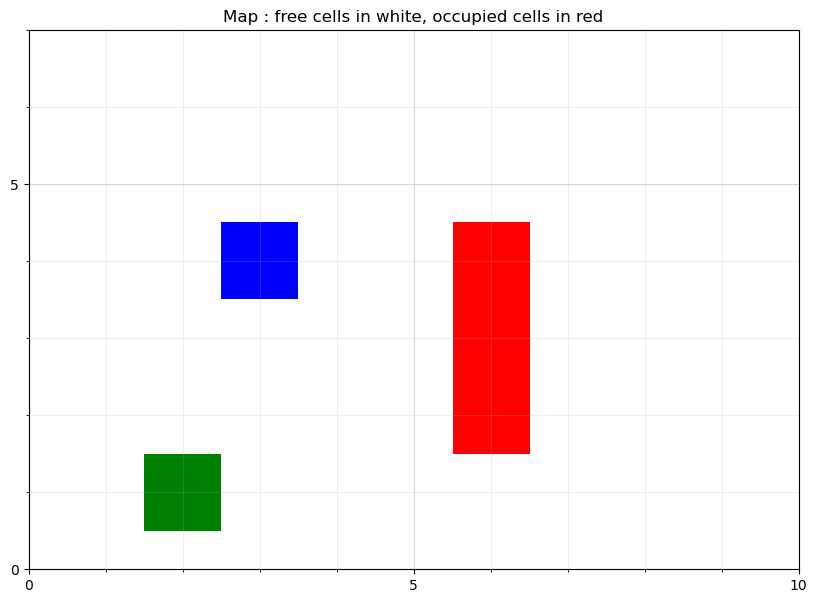

In [8]:
 # --------- DISPALY ENVIRONMENT --------- #
max_val_x = grid_height_cells
max_val_y = grid_width_cells
fig, ax = create_empty_plot(max_val_x,max_val_y)

# set plot origin to top left 
plt.xlim(0, max_val_x)
plt.ylim(0,max_val_y)

# Displaying the map
map_grid = np.copy(obs_grid)
map_grid[goals_in_blue[0],goals_in_blue[1]] = 2
map_grid[goals_in_green[0],goals_in_green[1]] = 3
cmap = colors.ListedColormap(['white', 'red', 'blue', 'green'])
# cmap = colors.ListedColormap(['white', 'red'])
ax.imshow(map_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red")

Starting position:  (8, 5)
Path:
 [[8 7 6 5 4 3 3]
 [5 5 5 5 5 5 4]]


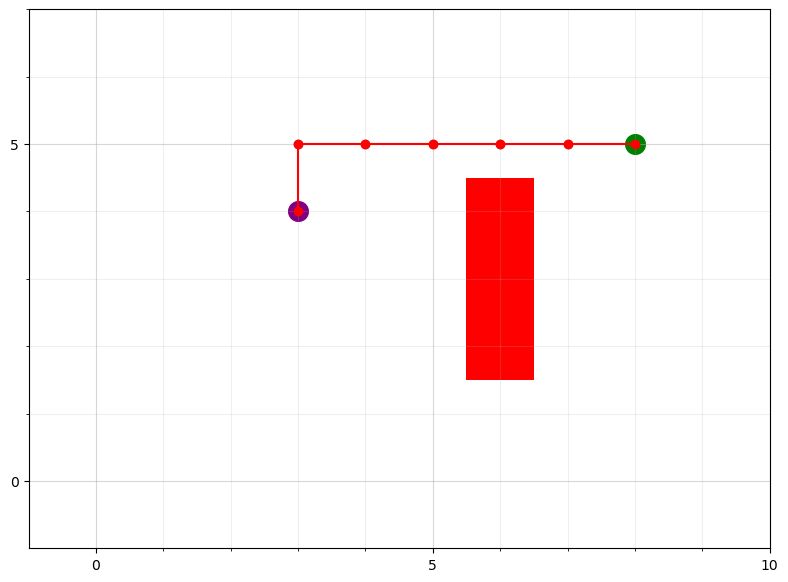

In [9]:
# --------- A* ALGORITHM --------- #
# Display A* algorithm result for the first target
# List of all coordinates in the grid
x, y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0] * x.shape[1], 2))
# Coords contains all the possible coordinates of the grid from (0,0) to (width-1, height-1)
coords = list([(int(x[0]), int(x[1])) for x in pos])


#Defining the start  point and end goal for now on
flag, _ ,state = get_thymio(cap)  # the starting position is the current position of the robot
if flag:
    start = [state[0],state[1]]
else:
    assert 0  # get_thymio failed

start = tuple([int(state[0]), int(state[1])])
print("Starting position: ", start)

#Defining the distance to the goal ignoring the obstacles, here using the Euclidian distance with the function np.linalg.norm
# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, max_val_x , max_val_y, movement_type="4N")
if path == []:
    print_error("Error in main: A* failed")
    assert 0  # A* failed
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
cmap = colors.ListedColormap(['white', 'red'])
ax_astar.imshow(obs_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color='grey')
ax_astar.plot(path[0], path[1], marker="o", color='red')
ax_astar.scatter(start[0], start[1], marker="o", color='green', s=200)
ax_astar.scatter(goal[0], goal[1], marker="o", color='purple', s=200)


print("Path:\n", path)

In [10]:
# defining variables and thresholds
index = 1
old_pos = start
target = tuple(path[:,1])
epsilon_target = 0.16
kidnapping_threshold = 2
is_kidnapped = False
sensor_scale = 200
old_pos = 0

prev_time = datetime.now()
first_run = True

# PID 
integral = 0.0
previous_error = 0.0
nearest_point_idx = 0

change_color = False
color1 = "red"
color2 = "blue"

 # --------- ITERATING ON EACH TARGET --------- #
for i in range(len(list_of_targets)):

    goal = list_of_targets[i]

    if i != 0:
        color2 = "green"
        # recompute path from current position to next goal
        start = tuple([int(pos[0]),int(pos[1])])
        path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
        await client.sleep(0.1)
        path = np.array(path).reshape(-1, 2).transpose()
        visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
        index = 1 #The index need to be re-initialized since we have a new path
        target = tuple(path[:,index])
        print(" The new path after reaching the target:\n", path)

    while len(path[0]) > index: 

        # --------- CHANGE LEDs COLOR --------- #
        if change_color:
            thymio.set_LEDs(color1)
            change_color = False
        else:
            thymio.set_LEDs(color2)
            change_color = True
        
        # --------- POSE AND KALMAN FILTER --------- #
        #Checking the state of camera and recording elapsed time
        camera_flag, _, state = get_thymio(cap)
        time_start = datetime.now()
        time_difference = (time_start - prev_time).total_seconds()
        prev_time = time_start

        #Motor speed
        speed_left, speed_right, prox = await thymio.get_sensors()
        speed = [speed_left,speed_right]
        

        if camera_flag:  # the camera is working
            if first_run:
                # this check is needed to properly set the elapsed time of the first iteration to zero
                time_difference = 0.0
                pos = [state[0], state[1]]
                P_est = np.eye(4)*1000
                first_run = False
            # updating Kalman filter
            speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed_left, speed_right, state[2], time_difference)
            x_prev = [pos[0],pos[1],speed_xy[0]/10,speed_xy[1]/10]
            P_prev = P_est
            kal_state, kal_speed, x_est, P_est, estimated_direction = tracker.predict(x_prev, P_prev,speed_xy, orientation_est, time_difference)

            # updating pose
            pos = [state[0],state[1]]
            angle = state[2]

        else:  # the camera is not working
            print_error("Error in main: camera not working")
            speed_xy, orientation_est, kal_angle = tracker.compute_x_y_speed(speed_left,speed_right,kal_angle,time_difference)
            x_prev = [pos[0],pos[1],speed_xy[0]/10,speed_xy[1]/10]
            P_prev = P_est
            kal_state,kal_speed,x_est,P_est,estimated_direction = tracker.predict(x_prev,P_prev, speed_xy, orientation_est,time_difference)

            # updating pose
            pos = [kal_state[0],kal_state[1]]
            angle = kal_angle
        
        # --------- KIDNAPPING --------- #
        old_pos = tuple(path[:,index-1])
        distance = math.sqrt((pos[0] - old_pos[0])**2 + (pos[1] - old_pos[1])**2)
        if ((distance > kidnapping_threshold) and (is_kidnapped == False)):
            print("The Thyimyo has been kidnapped")
            # recompute path from current position to goal
            thymio.set_motors_PID(0,0)
            start = tuple([int(pos[0]),int(pos[1])])
            path, visitedNodes = Global.A_Star(start, goal, h, coords, obs_grid, movement_type="4N")
            await client.sleep(0.1)
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
            index = 1 #The index need to be re-initialized since we have a new path
            target = tuple(path[:,index])
            is_kidnapped = True
            print(" The new path after kidnapping:\n", path)

        # TODO start leds and sound

    # --------- LOCAL AVOIDANCE --------- #
        obstacle_detected  = await local_nav.local_nav(thymio)
        if(obstacle_detected):
            obstacle_coordinates = local_nav.obstacle_extraction(obs_grid)
            status = local_nav.obstacle_function(path[:,index+1:index+5],pos, angle, thymio, obstacle_coordinates)
            obstacle_detected = False
            index = index+status
            target = tuple(path[:,index])  # updating target after performing local obtacle avoidance
            
    
        # --------- MOTION CONTROL --------- #
        left_speed, right_speed, _ = await thymio.get_sensors()
        vector_to_target = (target[0]+0.5 - pos[0], target[1]+0.5 - pos[1])
        vec0 = vector_to_target[0]
        # correcting the vector to target to compensate noise and errors
        if abs(vec0) < 0.15: vec0 = 0
        vec1 = vector_to_target[1]
        if abs(vec1) < 0.15: vec1 = 0
        
        target_angle = np.degrees(np.arctan2(vec1,vec0))  # angle of the vector to the next target
        target_angle = MotionControl.normalize_angle(target_angle)
        angle = MotionControl.normalize_angle(angle)  # robot's angle

        error = MotionControl.normalize_angle(target_angle - angle)  # error between the target angle and the robot's angle

        # condition to fullfil to reach the target
        f1 = (np.abs((target[1]+0.5-np.array(pos[1])) ) <= epsilon_target)
        f2 = (np.abs((target[0]+0.5-np.array(pos[0])) ) <= epsilon_target)
        f3 = (index<len(path[0]))  # still following the path
        if f1 and f2 and f3:
            # target reached
            if index == len(path[0])-1:
                print("Goal reached")
            else:
                # compute new target
                target = tuple(path[:,index+1])
            index = index+1
        else:
            updated_left_speed, updated_right_speed, integral, previous_error, _ = MotionControl.pid_controller(integral, error, previous_error, time_difference)
            thymio.set_motors_PID(updated_left_speed,updated_right_speed)
        await client.sleep(0.1)


    # stop the robot since the goal is reached
    thymio.set_motors_PID(0,0)
    thymio.set_LEDs("off")

Error in module.utils.grid_extraction: cannot classify corners correctly
Error in module.utils.grid_extraction: cannot classify corners correctly
Error in module.utils.grid_extraction: cannot classify corners correctly
Error in module.utils.grid_extraction: cannot classify corners correctly
Error in vision.functions.get_thymio: cannot find grid
Error in main: camera not working
Error in vision.functions.thymio_recognition: no markers found
Goal reached
 The new path after reaching the target:
 [[3 2 2 2 2]
 [4 4 3 2 1]]
Goal reached


In [27]:
# FIXME remove this
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
aw(node.set_variables(v))

In [26]:
# release the camera resource
cap.release()

In [18]:
# unlock the thymio
aw(node.unlock())

{'error_code': 2}